In [286]:
from path import Path
import sys
import plotly.graph_objects as go
import numpy as np
import scipy.spatial.distance
import math
import random
import utils

In [287]:
import random

def read_pts(file):
    verts = np.genfromtxt(file)
    #return utils.cent_norm(verts)
    return verts

def read_seg(file):
    verts = np.genfromtxt(file, dtype= (int))
    return verts

def sample_2000(pts, pts_cat):
    print(pts_cat.shape)
    res1 = np.concatenate((pts,np.reshape(pts_cat, (pts_cat.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=8000))
    images = res[:, 0:3]
    #print(images)
    categories = res[:,3]
    #print(categories)
    categories-=np.ones(categories.shape)
    #print(categories)
    return images, categories

In [288]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.dataset import random_split
import utils
root_dir=""
class Data(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, valid=False, transform=None):
        
        self.root_dir = root_dir
        self.files = []
        self.valid=valid

        dir1 = root_dir+'C2_label/'
        for file in os.listdir(dir1):
            o = {}
            o['category'] = dir1 + file
            o['img_path'] = root_dir + 'C2_points/'+ file.replace('.seg', '.pts')
            self.files.append(o)
       
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        category = self.files[idx]['category']
        with open(img_path, 'r') as f:
            image1 = read_pts(f)
        with open(category, 'r') as f:  
            category1 = read_seg(f)            
        image2, category2 = sample_2000(image1, category1)
        
        #print(image2)
        return {'image': np.array(image2, dtype="float32"), 'category': category2.astype(int)}
    

In [289]:
dset = Data(root_dir , transform=None)
train_num = int(len(dset) * 0.95)
val_num = int(len(dset) *0.05)
if int(len(dset)) - train_num -  val_num  >0 :
    train_num = train_num + 1
elif int(len(dset)) - train_num -  val_num  < 0:
    train_num = train_num -1
#train_dataset, val_dataset = random_split(dset, [3000, 118])
train_dataset, val_dataset = random_split(dset, [train_num, val_num])
val_dataset.valid=True

print('######### Dataset class created #########')
print('Number of images: ', len(dset))
print('Sample image shape: ', dset[0]['image'].shape)
#print('Sample image points categories', dset[0]['category'], end='\n\n')

train_loader = DataLoader(dataset=train_dataset, batch_size=8)
val_loader = DataLoader(dataset=val_dataset, batch_size=8)
#test_loader = DataLoader(dataset=test_dataset, batch_size=4)
#dataloader = torch.utils.data.DataLoader(dset, batch_size=4, shuffle=True, num_workers=4

######### Dataset class created #########
Number of images:  1000
(8000,)
Sample image shape:  (8000, 3)


In [290]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=128)
        self.fc1 = nn.Conv1d(3,64,1)
        self.fc2 = nn.Conv1d(64,128,1) 
        self.fc3 = nn.Conv1d(128,128,1)
        self.fc4 = nn.Conv1d(128,512,1)
        self.fc5 = nn.Conv1d(512,2048,1)

        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(2048)

   def forward(self, input):
        n_pts = input.size()[2]
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        outs = []
        
        out1 = F.relu(self.bn1(self.fc1(xb)))
        outs.append(out1)
        out2 = F.relu(self.bn2(self.fc2(out1)))
        outs.append(out2)
        out3 = F.relu(self.bn3(self.fc3(out2)))
        outs.append(out3)
        matrix128x128 = self.feature_transform(out3)
        
        out4 = torch.bmm(torch.transpose(out3,1,2), matrix128x128).transpose(1,2) 
        outs.append(out4)
        out5 = F.relu(self.bn4(self.fc4(out4)))
        outs.append(out5)
       
        xb = self.bn5(self.fc5(out5))
        
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        out6 = nn.Flatten(1)(xb).repeat(n_pts,1,1).transpose(0,2).transpose(0,1)#.repeat(1, 1, n_pts)
        outs.append(out6)
        
        
        return outs, matrix3x3, matrix128x128


class PointNetSeg(nn.Module):
    def __init__(self, classes = 6):
        super().__init__()
        self.transform = Transform()

        self.fc1 = nn.Conv1d(3008,256,1) 
        self.fc2 = nn.Conv1d(256,256,1) 
        self.fc3 = nn.Conv1d(256,128,1) 
        self.fc4 = nn.Conv1d(128,6,1) 
        

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(6)
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input):
        inputs, matrix3x3, matrix128x128 = self.transform(input)
        stack = torch.cat(inputs,1)
        
        xb = F.relu(self.bn1(self.fc1(stack)))
       
        xb = F.relu(self.bn2(self.fc2(xb)))
    
        xb = F.relu(self.bn3(self.fc3(xb)))
        
        output = F.relu(self.bn4(self.fc4(xb)))
        
        return self.logsoftmax(output), matrix3x3, matrix128x128

In [291]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [292]:
pointnet = PointNetSeg()
pointnet.to(device);
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [293]:
def pointnetloss(outputs, labels, m3x3, m128x128, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id128x128 = torch.eye(128, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id128x128=id128x128.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff128x128 = id128x128-torch.bmm(m128x128,m128x128.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff128x128)) / float(bs)

In [294]:
def train(model, train_loader, val_loader=None,  epochs=200, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['image'].to(device), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['image'].to(device), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0) * labels.size(1) ##
                    correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total
            print('Valid accuracy: %d %%' % val_acc)
            print(val_acc)
        # save the model
        if save:
            torch.save(pointnet.state_dict(), root_dir+"M2_Result/"+str(epoch)+"_"+str(val_acc))

In [295]:
train(pointnet, train_loader, val_loader,  save=True)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[1,    10] loss: 1.882
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 24 %
24.68275
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[2,    10] loss: 0.962
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(80

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 63 %
63.46725
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[3,    10] loss: 0.706
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(80

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 87 %
87.79475
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[4,    10] loss: 0.526
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(80

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 72 %
72.2345
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[5,    10] loss: 0.432
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(800

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 89 %
89.73725
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[6,    10] loss: 0.344
(80

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 88 %
88.74125
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8

(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 80 %
80.227
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(800

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 87 %
87.85025
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8

(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 90 %
90.262
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 92 %
92.963
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 92 %
92.921
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 94 %
94.698
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.18
(8000,)
(8000,)
(8000,)
(8000,)
(8000

(8000,)
(8000,)
(8000,)
(8000,)
[14,   110] loss: 0.129
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[15,   110] loss: 0.131
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[16,   110] loss: 0.153
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[17,   110] loss: 0.143
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)


(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[18,   110] loss: 0.119
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[19,   110] loss: 0.102
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)


(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[20,   110] loss: 0.093
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


[21,   100] loss: 0.100
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[21,   110] loss: 0.089
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[22,   100] loss: 0.106
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[22,   110] loss: 0.093
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[23,   100] loss: 0.096
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[23,   110] loss: 0.089
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[24,   100] loss: 0.090
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[24,   110] loss: 0.077
(8000,)
(8000,)
(8000,)


(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[25,   100] loss: 0.109
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[26,   100] loss: 0.090
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)


(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[27,   100] loss: 0.088
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


[28,    90] loss: 0.177
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[28,   100] loss: 0.146
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[29,    90] loss: 0.106
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[29,   100] loss: 0.092
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[30,    90] loss: 0.102
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[30,   100] loss: 0.093
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)


(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[31,    90] loss: 0.111
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[31,   100] loss: 0.082
(8000,)
(8008,)
(8000,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[32,    90] loss: 0.080
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[33,    90] loss: 0.093
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[34,    90] loss: 0.072
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)


[35,    80] loss: 0.072
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[35,    90] loss: 0.070
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[36,    80] loss: 0.065
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[36,    90] loss: 0.066
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[37,    80] loss: 0.064
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[37,    90] loss: 0.068
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[38,    80] loss: 0.078
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[38,    90] loss: 0.070
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[39,    80] loss: 0.061
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[40,    80] loss: 0.078
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[41,    80] loss: 0.061
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


[42,    70] loss: 0.080
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[42,    80] loss: 0.060
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[43,    70] loss: 0.083
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[43,    80] loss: 0.058
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[44,    70] loss: 0.296
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[44,    80] loss: 0.153
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[45,    70] loss: 0.206
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[45,    80] loss: 0.093
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[46,    70] loss: 0.304
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[47,    70] loss: 0.315
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[48,    70] loss: 0.107
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8008,)
[49,    60] loss: 0.065
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[49,    70] loss: 0.095
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[50,    60] loss: 0.061
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[50,    70] loss: 0.081
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[51,    60] loss: 0.053
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[51,    70] loss: 0.074
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[52,    60] loss: 0.049
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[52,    70] loss: 0.063
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[53,    60] loss: 0.051
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[54,    60] loss: 0.045
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[55,    60] loss: 0.045
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


[56,    50] loss: 0.048
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[56,    60] loss: 0.050
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[57,    50] loss: 0.050
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[57,    60] loss: 0.048
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[58,    50] loss: 0.050
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[58,    60] loss: 0.050
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[59,    50] loss: 0.042
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[59,    60] loss: 0.043
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[60,    50] loss: 0.058
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[61,    50] loss: 0.042
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[62,    50] loss: 0.047
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


[63,    40] loss: 0.038
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[63,    50] loss: 0.043
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[64,    40] loss: 0.058
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[64,    50] loss: 0.058
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[65,    40] loss: 0.036
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[65,    50] loss: 0.035
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[66,    40] loss: 0.049
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[66,    50] loss: 0.052
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[67,    40] loss: 0.042
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[68,    40] loss: 0.038
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[69,    40] loss: 0.039
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
[70,    30] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[70,    40] loss: 0.040
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[71,    30] loss: 0.037
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[71,    40] loss: 0.037
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[72,    30] loss: 0.041
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[72,    40] loss: 0.039
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)


(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[73,    30] loss: 0.039
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[73,    40] loss: 0.039
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[74,    30] loss: 0.031
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[75,    30] loss: 0.048
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[76,    30] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)


[77,    20] loss: 0.034
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[77,    30] loss: 0.038
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[78,    20] loss: 0.036
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[78,    30] loss: 0.041
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[79,    20] loss: 0.166
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[79,    30] loss: 0.243
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[80,    20] loss: 0.051
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[80,    30] loss: 0.050
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[81,    20] loss: 0.035
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[82,    20] loss: 0.053
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[83,    20] loss: 0.037
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)


[84,    10] loss: 0.028
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[84,    20] loss: 0.031
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[85,    10] loss: 0.025
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[85,    20] loss: 0.026
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[86,    10] loss: 0.027
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[86,    20] loss: 0.028
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[87,    10] loss: 0.026
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[87,    20] loss: 0.029
(8000,)
(8000,)
(8008,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[88,    10] loss: 0.033
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[89,    10] loss: 0.028
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)


(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[90,    10] loss: 0.029
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)


(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[91,    10] loss: 0.026
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)


(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.6105
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[92,    10] loss: 0.028
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(80

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 97 %
97.69975
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[93,    10] loss: 0.025
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 97 %
97.30525
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[94,    10] loss: 0.024
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8

(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.30475
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.13925
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 97 %
97.73
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000

(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 97 %
97.6085
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(80

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 69 %
69.2165
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(80

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 86 %
86.88
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 94 %
94.687
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.4245
(8000,)
(80

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[102,   110] loss: 0.025
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[103,   110] loss: 0.022
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[104,   110] loss: 0.021
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[105,   110] loss: 0.021
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[106,   110] loss: 0.022
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[107,   110] loss: 0.020
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[108,   110] loss: 0.024
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)

(8000,)
(8000,)
(8000,)
(8008,)
[109,   100] loss: 0.023
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[109,   110] loss: 0.019
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[110,   100] loss: 0.024
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[110,   110] loss: 0.020
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[111,   100] loss: 0.326
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[111,   110] loss: 0.248
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,

(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[112,   100] loss: 0.145
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[112,   110] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[113,   100] loss: 0.141
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[114,   100] loss: 0.097
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[115,   100] loss: 0.088
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
[116,    90] loss: 0.061
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[116,   100] loss: 0.060
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[117,    90] loss: 0.062
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[117,   100] loss: 0.056
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[118,    90] loss: 0.061
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[118,   100] loss: 0.058
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[119,    90] loss: 0.055
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[119,   100] lo

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[120,    90] loss: 0.044
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[121,    90] loss: 0.045
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[122,    90] loss: 0.044
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8008,)
[123,    80] loss: 0.041
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[123,    90] loss: 0.040
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[124,    80] loss: 0.124
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[124,    90] loss: 0.095
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[125,    80] loss: 0.073
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[125,    90] loss: 0.082
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[126,    80] loss: 0.047
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[126,    90] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[127,    80] loss: 0.043
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[128,    80] loss: 0.063
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[129,    80] loss: 0.042
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)

(8000,)
(8000,)
(8008,)
(8000,)
[130,    70] loss: 0.057
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[130,    80] loss: 0.035
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[131,    70] loss: 0.056
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[131,    80] loss: 0.040
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[132,    70] loss: 0.045
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[132,    80] loss: 0.039
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[133,    70] loss: 0.050
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[133,    80] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[134,    70] loss: 0.048
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[135,    70] loss: 0.044
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[136,    70] loss: 0.283
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8008,)
(8000,)
(8000,)
(8008,)
[137,    60] loss: 0.053
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[137,    70] loss: 0.090
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[138,    60] loss: 0.036
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[138,    70] loss: 0.067
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[139,    60] loss: 0.030
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[139,    70] loss: 0.054
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[140,    60] loss: 0.030
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
[140,    70] lo

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[141,    60] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[142,    60] loss: 0.031
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[143,    60] loss: 0.058
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
[144,    50] loss: 0.052
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[144,    60] loss: 0.042
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[145,    50] loss: 0.033
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[145,    60] loss: 0.029
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,

(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[146,    50] loss: 0.100
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[146,    60] loss: 0.066
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[147,    50] loss: 0.048
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
[147,    60] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[148,    50] loss: 0.037
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[149,    50] loss: 0.035
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[150,    50] loss: 0.035
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
[151,    40] loss: 0.027
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[151,    50] loss: 0.029
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,

(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[152,    40] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[152,    50] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[153,    40] loss: 0.029
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[153,    50] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[154,    40] loss: 0.033
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
[154,    50] lo

(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[155,    40] loss: 0.032
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[156,    40] loss: 0.026
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[157,    40] loss: 0.030
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
[158,    30] loss: 0.027
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[158,    40] loss: 0.026
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[159,    30] loss: 0.026
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[159,    40] loss: 0.026
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[160,    30] loss: 0.028
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[160,    40] loss: 0.028
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[161,    30] loss: 0.024
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[161,    40] lo

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[162,    30] loss: 0.025
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[163,    30] loss: 0.023
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[164,    30] loss: 0.026
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8008,)
(8000,)
(8008,)
(8000,)
[165,    20] loss: 0.028
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[165,    30] loss: 0.030
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[166,    20] loss: 0.028
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[166,    30] loss: 0.031
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[167,    20] loss: 0.024
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[167,    30] loss: 0.025
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[168,    20] loss: 0.024
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
[168,    30] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[169,    20] loss: 0.025
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[170,    20] loss: 0.026
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[171,    20] loss: 0.023
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8008,)
(8000,)
(8000,)
[172,    10] loss: 0.024
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[172,    20] loss: 0.033
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[173,    10] loss: 0.056
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[173,    20] loss: 0.069
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8008,)
(8008,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[174,    10] loss: 0.032
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[174,    20] loss: 0.034
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[175,    10] loss: 0.024
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
[175,    20] lo

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[176,    10] loss: 0.023
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[177,    10] loss: 0.023
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[178,    10] loss: 0.022
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.16075
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[179,    10] loss: 0.023
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(

(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.01575
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[180,    10] loss: 0.021
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 94 %
94.50075
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
[181,    10] loss: 0.021
(8000,)
(8008,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(

(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.1
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,

(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.063
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(800

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.9455
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(80

(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.83425
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.202
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(800

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 95 %
95.89575
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy: 96 %
96.43825
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8

[188,   110] loss: 0.017
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
Valid accuracy:

(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[189,   110] loss: 0.022
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)

(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[190,   110] loss: 0.018
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)

(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[191,   110] loss: 0.018
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[192,   110] loss: 0.019
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[193,   110] loss: 0.017
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)

(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[194,   110] loss: 0.021
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)

[195,   100] loss: 0.019
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[195,   110] loss: 0.016
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[196,   100] loss: 0.021
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[196,   110] loss: 0.017
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,

(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[197,   100] loss: 0.028
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[197,   110] loss: 0.023
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,

(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[198,   100] loss: 0.022
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
[198,   110] loss: 0.019
(8000,)
(8000,

(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[199,   100] loss: 0.072
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)

(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
[200,   100] loss: 0.033
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8008,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)
(8000,)
(8008,)
(8000,)
(8000,)

No handles with labels found to put in legend.


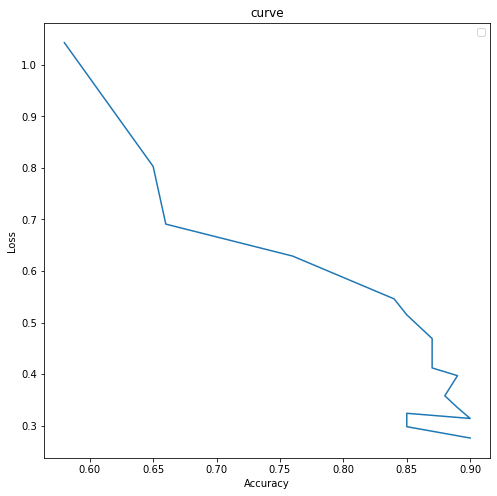

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.title("curve")
x=[1.043,0.803,0.691,0.629,0.546,0.515,0.469,0.412,0.397,0.358,0.335,0.314,0.324,0.298,0.276]
y=[0.58,0.65,0.66,0.76,0.84,0.85,0.87,0.87,0.89,0.88,0.89,0.90,0.85,0.85,0.90]
#plt.plot([1.043,0.803,0.691,0.629,0.546,0.515,0.469,0.412,0.397,0.358,0.335,0.314,0.324,0.298,0.276],[0.58,0.76,0.65,0.79,0.84,0.85,0.79,0.87,0.89,0.88,0.89,0.90,0.85,0.85,0.90])
#fig,ax = plt.subplots()
plt.plot(y,x)
plt.show
plt.ylabel("Loss")
plt.xlabel("Accuracy")
plt.legend();

In [25]:
pointnet = PointNetSeg()
pointnet.load_state_dict(torch.load("save.pth"))
pointnet.eval()

RuntimeError: Error(s) in loading state_dict for PointNetSeg:
	Missing key(s) in state_dict: "transform.fc1.weight", "transform.fc1.bias", "transform.fc2.weight", "transform.fc2.bias", "transform.fc3.weight", "transform.fc3.bias", "transform.fc4.weight", "transform.fc4.bias", "transform.fc5.weight", "transform.fc5.bias", "transform.bn4.weight", "transform.bn4.bias", "transform.bn4.running_mean", "transform.bn4.running_var", "transform.bn5.weight", "transform.bn5.bias", "transform.bn5.running_mean", "transform.bn5.running_var", "fc4.weight", "fc4.bias", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "bn4.weight", "bn4.bias", "bn4.running_mean", "bn4.running_var". 
	Unexpected key(s) in state_dict: "transform.conv1.weight", "transform.conv1.bias", "transform.conv2.weight", "transform.conv2.bias", "transform.conv3.weight", "transform.conv3.bias". 
	size mismatch for transform.feature_transform.conv1.weight: copying a param with shape torch.Size([64, 64, 1]) from checkpoint, the shape in current model is torch.Size([64, 128, 1]).
	size mismatch for transform.feature_transform.fc3.weight: copying a param with shape torch.Size([4096, 256]) from checkpoint, the shape in current model is torch.Size([16384, 256]).
	size mismatch for transform.feature_transform.fc3.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([16384]).
	size mismatch for transform.bn3.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transform.bn3.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transform.bn3.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transform.bn3.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([256, 3008, 1]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([256, 256, 1]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([10, 256]) from checkpoint, the shape in current model is torch.Size([128, 256, 1]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bn1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bn1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bn1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for bn1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).

In [403]:
pointnet = PointNetSeg()
pointnet.load_state_dict(torch.load(root_dir+"M2_Result/"+"122_94.88925"))
pointnet.eval()

PointNetSeg(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(128, 64, kernel_size

In [298]:
batch = next(iter(val_loader))
'''print(batch)
print(type(batch['image']))
print(type(batch['image'].transpose(1,2)))'''
'''print(batch['image'].shape)
print(batch['image'].size())
print(batch['image'].transpose(1,2).shape)'''
pred = pointnet(batch['image'].transpose(1,2))
print(pred[0])
pred_np = np.array(torch.argmax(pred[0],1));
pred_np

(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
(8000,)
tensor([[[-1.0439e+01, -8.2466e+00, -9.6733e+00,  ..., -1.0220e+01,
          -9.9118e+00, -8.6459e+00],
         [-1.0439e+01, -8.2466e+00, -1.0845e+01,  ..., -1.8216e-04,
          -2.6755e-04, -9.5626e+00],
         [-1.4836e-04, -1.7536e-02, -1.0845e+01,  ..., -1.0220e+01,
          -9.9118e+00, -4.7307e-04],
         [-1.0373e+01, -4.1145e+00, -1.4094e-04,  ..., -1.0220e+01,
          -9.5790e+00, -9.3591e+00],
         [-1.0439e+01, -8.2466e+00, -1.0845e+01,  ..., -1.0220e+01,
          -9.9118e+00, -9.5626e+00],
         [-1.0439e+01, -8.2466e+00, -1.0845e+01,  ..., -1.0220e+01,
          -9.9118e+00, -9.5626e+00]],

        [[-1.0292e+01, -1.1512e+01, -7.1314e+00,  ..., -1.1501e+01,
          -9.1904e+00, -1.1494e+01],
         [-1.6951e-04, -1.1729e+01, -5.7427e-01,  ..., -1.1501e+01,
          -9.1904e+00, -1.1494e+01],
         [-1.0292e+01, -1.1729e+01, -7.2240e+00,  ..., -5.0592e-05,
          -8.5993e-03, -5.

array([[2, 2, 3, ..., 1, 1, 2],
       [1, 3, 1, ..., 2, 2, 2],
       [3, 3, 1, ..., 2, 3, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [1, 0, 0, ..., 1, 2, 0],
       [0, 2, 2, ..., 1, 2, 1]])

In [26]:
batch['image'][0][1].tolist()

[18.196704864501953, -82.6865005493164, 107.67254638671875]

In [35]:
data=[]
for i in range(0,len(batch['image'][0])):
    tmp=[]
    tmp=batch['image'][0][i].tolist()
    data.append(str(tmp[0])+" "+str(tmp[1])+" "+str(tmp[2])+" "+str(pred_np[0].tolist()[i]+1)+"\n")
for i in range(0,len(batch['image'][0])):
    print(data[i])
f=open("test.pts","w")
f.writelines(data)
f.close()

24.226242065429688 -90.76836395263672 116.78592681884766 1

18.196704864501953 -82.6865005493164 107.67254638671875 2

27.38060188293457 -84.20645904541016 119.05105590820312 1

26.30450439453125 -63.04301071166992 120.61874389648438 1

36.74424743652344 -70.25414276123047 81.09659576416016 2

26.378265380859375 -78.59916687011719 91.17115783691406 2

7.8924455642700195 -82.67667388916016 117.49005889892578 2

18.526836395263672 -86.57389831542969 108.95634460449219 2

36.17512130737305 -79.14634704589844 82.17476654052734 2

27.680805206298828 -82.30073547363281 67.9296875 2

0.6958469152450562 -72.2425308227539 99.54356384277344 2

27.215662002563477 -66.15432739257812 98.7571792602539 2

13.640995025634766 -61.627079010009766 92.16886138916016 2

27.79292106628418 -87.55032348632812 109.68330383300781 2

25.219850540161133 -88.51570892333984 119.42547607421875 1

-5.226672172546387 -84.2942886352539 106.54060363769531 2

33.97119903564453 -77.62246704101562 110.58477783203125 1

13.

8.279740333557129 -79.07454681396484 81.96150207519531 2

18.135406494140625 -74.2596664428711 104.80326843261719 2

27.33250617980957 -76.69829559326172 101.5608139038086 2

31.526418685913086 -73.98538970947266 117.32807922363281 1

-10.80543327331543 -74.98164367675781 121.60792541503906 1

27.717248916625977 -77.60723114013672 119.39057159423828 1

-3.752056121826172 -75.34918975830078 113.1553726196289 1

-8.652374267578125 -79.08023071289062 99.60449981689453 2

15.963494300842285 -60.82019805908203 94.09690856933594 2

30.360013961791992 -71.52227020263672 124.34170532226562 1

1.7249490022659302 -67.85521697998047 118.38093566894531 1

13.386005401611328 -94.58992004394531 118.65724182128906 1

2.4424314498901367 -75.6251449584961 109.95577239990234 2

-4.40057897567749 -71.13209533691406 94.77197265625 2

-3.8588688373565674 -69.15121459960938 118.80023956298828 1

13.315484046936035 -61.561195373535156 64.62420654296875 2

19.543731689453125 -61.78822326660156 117.18453979492


12.410140037536621 -60.12360763549805 101.72494506835938 2

0.8496249914169312 -71.1844711303711 106.53168487548828 2

-1.4538795948028564 -64.3108901977539 116.96958923339844 1

37.427555084228516 -69.47957611083984 126.76004791259766 1

-7.418081760406494 -75.8407211303711 99.1263656616211 2

-5.531091690063477 -69.75791931152344 97.216064453125 2

25.015100479125977 -75.91752624511719 114.25511169433594 1

-3.7383151054382324 -72.57048034667969 82.83915710449219 2

22.007244110107422 -86.07990264892578 68.05484008789062 2

29.43414878845215 -69.17161560058594 71.0510482788086 2

37.27011489868164 -69.62902069091797 85.66494750976562 2

36.83370590209961 -79.74610137939453 117.79975891113281 1

15.376569747924805 -53.57331466674805 97.3274154663086 2

26.825397491455078 -83.70146179199219 85.02598571777344 2

34.5360107421875 -81.3104248046875 104.10786437988281 2

-7.008328914642334 -73.01079559326172 119.23739624023438 1

2.5473177433013916 -73.831787109375 84.09868621826172 2

33


13.495738983154297 -77.57209014892578 75.67555236816406 2

22.96741485595703 -76.21267700195312 118.50060272216797 1

31.401586532592773 -83.11827087402344 118.93256378173828 1

21.142757415771484 -60.41222381591797 100.67573547363281 2

-2.984548807144165 -80.08610534667969 110.49537658691406 1

12.10842227935791 -91.9788818359375 125.0306396484375 1

0.8166265487670898 -76.49413299560547 112.94286346435547 1

-1.506403923034668 -93.31999206542969 121.22136688232422 1

11.299480438232422 -61.097618103027344 84.20465087890625 2

30.758590698242188 -67.82524108886719 102.76175689697266 2

13.124701499938965 -76.69624328613281 89.80159759521484 2

36.5341796875 -78.50580596923828 125.39253997802734 1

22.474239349365234 -79.13331604003906 95.128173828125 2

32.25840759277344 -73.8119888305664 116.11670684814453 1

11.170093536376953 -77.53803253173828 96.09571838378906 2

15.887993812561035 -49.777339935302734 99.00593566894531 2

23.431537628173828 -85.37665557861328 108.21369934082031

In [13]:
batch['image'][0].T

tensor([[ 24.2262,  18.1967,  27.3806,  ...,   3.0451,  33.8518,   5.4940],
        [-90.7684, -82.6865, -84.2065,  ..., -93.4214, -73.3931, -67.6065],
        [116.7859, 107.6725, 119.0511,  ..., 118.2354, 113.1921,  97.2818]])

In [30]:
pred_np[0].tolist()

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,


In [14]:
pred_np[0].T

array([0, 1, 0, ..., 0, 0, 1])

In [299]:
x,y,z=np.array(batch['image'][6]).T
c =pred_np[6].T

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, 
                                   mode='markers',
                                   marker=dict(
        size=50,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0
    ))])
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

"\nplt.subplot(1,2,2)\nplt.plot(siamese_net.history.history['loss'])\nplt.plot(siamese_net.history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'valid'], loc='upper left')\nplt.show()\nplt.show()\n"

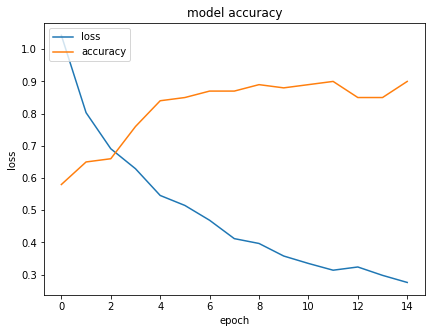

In [88]:
#Plot Loss and Accuracy
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot([1.043,0.803,0.691,0.629,0.546,0.515,0.469,0.412,0.397,0.358,0.335,0.314,0.324,0.298,0.276])
plt.plot([0.58,0.65,0.66,0.76,0.84,0.85,0.87,0.87,0.89,0.88,0.89,0.90,0.85,0.85,0.90])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
'''
plt.subplot(1,2,2)
plt.plot(siamese_net.history.history['loss'])
plt.plot(siamese_net.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
plt.show()
'''

In [43]:
x,y,z=np.array(batch['image'][2]).T
c =pred_np[2].T

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, 
                                   mode='markers',
                                   marker=dict(
        size=50,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0
    ))])
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

IndexError: index 2 is out of bounds for axis 0 with size 1

In [406]:
pointnet = PointNetSeg()
pointnet.load_state_dict(torch.load(root_dir+"M2_Result/"+"125_96.64525"))
pointnet.eval()

PointNetSeg(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(128, 64, kernel_size

In [409]:
v=read_pts("8000_test.pts")
v=np.float32(v)
print(v.shape)
v=v.reshape((1,8000,3))
print(v.shape)
gif=torch.tensor(v)
print(gif[0])
print(type(gif))
print(gif.shape)
print(gif.size())

pred = pointnet(gif.transpose(1,2))
#print(pred[0])
pred_np = np.array(torch.argmax(pred[0],1));


x,y,z=np.array(gif[0]).T
c =pred_np[0].T

print(c)

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, 
                                   mode='markers',
                                   marker=dict(
        size=50,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0
    ))])
fig.update_traces(marker=dict(size=3,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

(8000, 3)
(1, 8000, 3)
tensor([[-21.5593,  34.1699, 994.2079],
        [ 10.5226,  30.8292, 984.5422],
        [ -9.3584,  18.2764, 993.7560],
        ...,
        [ 31.9395,  21.3342, 985.8262],
        [-24.8637,  35.2068, 993.9352],
        [-17.0681,  38.8929, 990.8819]])
<class 'torch.Tensor'>
torch.Size([1, 8000, 3])
torch.Size([1, 8000, 3])
[3 3 3 ... 3 3 3]


In [ ]:
data=[]
for i in range(0,len(gif[0])):
    tmp=[]
    tmp=gif[0][i].tolist()
    data.append(str(tmp[0])+" "+str(tmp[1])+" "+str(tmp[2])+" "+str(pred_np[0].tolist()[i]+1)+"\n")
'''for i in range(0,len(gif[0][0])):
    print(data[i])'''
f=open("test.pts","w")
f.writelines(data)
f.close()